# Vortex Lattice Method

## Point Analysis

In [1]:
import aerosandbox as asb
import aerosandbox.numpy as np

wing_airfoil = asb.Airfoil("sd7037")
tail_airfoil = asb.Airfoil("naca0010")

### Define the 3D geometry you want to analyze/optimize.
# Here, all distances are in meters and all angles are in degrees.
airplane = asb.Airplane(
    name="Peter's Glider",
    xyz_ref=[0, 0, 0],  # CG location
    wings=[
        asb.Wing(
            name="Main Wing",
            symmetric=True,  # Should this wing be mirrored across the XZ plane?
            xsecs=[  # The wing's cross ("X") sections
                asb.WingXSec(  # Root
                    xyz_le=[0, 0, 0],  # Coordinates of the XSec's leading edge, relative to the wing's leading edge.
                    chord=0.18,
                    twist=2,  # degrees
                    airfoil=wing_airfoil,  # Airfoils are blended between a given XSec and the next one.
                ),
                asb.WingXSec(  # Mid
                    xyz_le=[0.01, 0.5, 0],
                    chord=0.16,
                    twist=0,
                    airfoil=wing_airfoil,
                ),
                asb.WingXSec(  # Tip
                    xyz_le=[0.08, 1, 0.1],
                    chord=0.08,
                    twist=-2,
                    airfoil=wing_airfoil,
                ),
            ]
        ),
        asb.Wing(
            name="Horizontal Stabilizer",
            symmetric=True,
            xsecs=[
                asb.WingXSec(  # root
                    xyz_le=[0, 0, 0],
                    chord=0.1,
                    twist=-10,
                    airfoil=tail_airfoil,
                ),
                asb.WingXSec(  # tip
                    xyz_le=[0.02, 0.17, 0],
                    chord=0.08,
                    twist=-10,
                    airfoil=tail_airfoil
                )
            ]
        ).translate([0.6, 0, 0.06]),
        asb.Wing(
            name="Vertical Stabilizer",
            symmetric=False,
            xsecs=[
                asb.WingXSec(
                    xyz_le=[0, 0, 0],
                    chord=0.1,
                    twist=0,
                    airfoil=tail_airfoil,
                ),
                asb.WingXSec(
                    xyz_le=[0.04, 0, 0.15],
                    chord=0.06,
                    twist=0,
                    airfoil=tail_airfoil
                )
            ]
        ).translate([0.6, 0, 0.07])
    ],
    fuselages=[
        asb.Fuselage(
            name="Fuselage",
            xsecs=[
                asb.FuselageXSec(
                    xyz_c=[0.8 * xi - 0.1, 0, 0.1 * xi - 0.03],
                    radius=0.6 * asb.Airfoil("dae51").local_thickness(x_over_c=xi)
                )
                for xi in np.cosspace(0, 1, 30)
            ]
        )
    ]
)

In [2]:
vlm = asb.VortexLatticeMethod(
    airplane=airplane,
    op_point=asb.OperatingPoint(
        velocity=25, # m/s
        alpha=5, # degree
    )
)

C:\GitHub\AeroSandbox\aerosandbox\geometry\wing.py:264: UserWarning: Warning: Using a placeholder aerodynamics model for this Airfoil!
It's highly recommended that you either:
	a) Specify polar functions in the Airfoil constructor, or
	b) Call Airfoil.generate_polars() to auto-generate these polar functions with XFoil.
  if not xsec.airfoil.CL_function(0, 1e6, 0, 0) == 0:  # Surface has to have a symmetric airfoil.
C:\GitHub\AeroSandbox\aerosandbox\geometry\wing.py:266: UserWarning: Warning: Using a placeholder aerodynamics model for this Airfoil!
It's highly recommended that you either:
	a) Specify polar functions in the Airfoil constructor, or
	b) Call Airfoil.generate_polars() to auto-generate these polar functions with XFoil.
  if not xsec.airfoil.CM_function(0, 1e6, 0, 0) == 0:  # Surface has to have a symmetric airfoil.


You can change the paneling by passing in various parameters to the `VortexLatticeMethod` constructor, or by using `analysis_specific_options` for various components (`Wing`, `WingXSec`, etc.) These options are viewable in the source code.

In [3]:
aero = vlm.run() # Returns a dictionary
for k, v in aero.items():
    print(f"{k.rjust(4)} : {v}")

   L : 80.20940137630318
   D : 1.5500742218811423
   Y : 7.706855400298031e-16
   l : -2.839478665173283e-15
   m : -2.255208490849847
   n : 6.874722327848233e-16
  CL : 0.7166310680840677
  CD : 0.013849141449451634
  CY : 6.8856916051199124e-18
  Cl : -1.256025607871831e-17
  Cm : -0.13339717342124371
  Cn : 3.0409903749914856e-18
 F_g : [-5.44653423e+00  7.70685540e-16  8.00392783e+01]
 F_w : (-1.5500742218811423, 7.706855400298031e-16, -80.20940137630318)
 M_g : [ 2.88859074e-15 -2.25520849e+00 -4.37379321e-16]
 M_w : (-2.839478665173283e-15, -2.255208490849847, 6.874722327848233e-16)


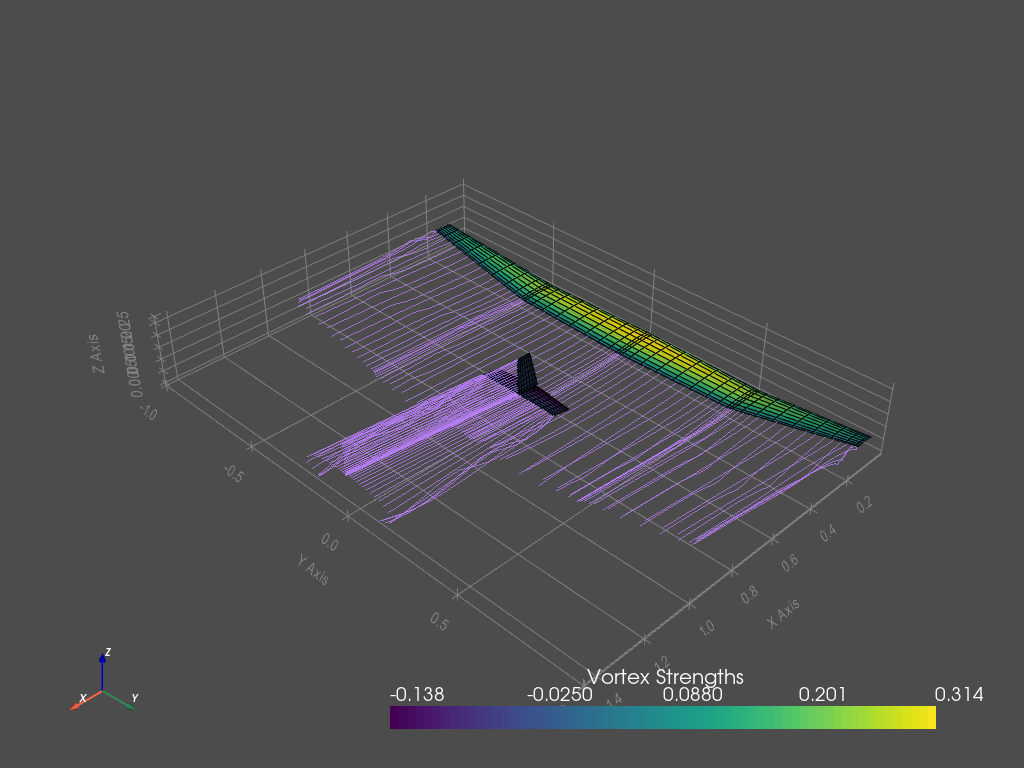

In [4]:
# NBVAL_SKIP

vlm.draw(show_kwargs=dict(jupyter_backend="static"))

## Operating Point Optimization

In [8]:
opti = asb.Opti()

alpha = opti.variable(init_guess=5)

vlm = asb.VortexLatticeMethod(
    airplane=airplane,
    op_point=asb.OperatingPoint(
        velocity=25,
        alpha=alpha
    ),
    align_trailing_vortices_with_wind=False,
)

aero = vlm.run()

L_over_D = aero["CL"] / aero["CD"]

opti.minimize(-L_over_D)

sol = opti.solve()

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        1

Total number of variables............................:        1
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 -

In [9]:
best_alpha = sol.value(alpha)
print(f"Alpha for max L/D: {best_alpha:.3f} deg")

Alpha for max L/D: 2.632 deg


## Aerodynamic Shape Optimization